# Use Case 1: Kögur
In this example we will subsample a dataset stored on SciServer using methods resembling field-work procedures.
Specifically, we will estimate volume fluxes through the [Kögur section](http://kogur.whoi.edu) using (i) mooring arrays, and (ii) ship surveys.

In [1]:
# Import oceanspy
import oceanspy as ospy

# Import additional packages used in this notebook
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Start client
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45457 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 257.77 GB


In [3]:
# Change default figure size
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [10.0, 5.0]

In [4]:
# Open dataset stored on SciServer.
od = ospy.open_oceandataset.from_catalog('EGshelfIIseas2km_ASR_full')

Opening EGshelfIIseas2km_ASR_full.


/home/idies/miniconda3/lib/python3.7/site-packages/dask/array/blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


High-resolution (~2km) numerical simulation covering the east Greenland shelf (EGshelf), 
and the Iceland and Irminger Seas (IIseas) forced by the Arctic System Reanalysis (ASR). 
Citation:
 * Almansi et al., 2017 - JPO.
Characteristics:
 * full: Full domain without variables to close budgets.
See also:
 * EGshelfIIseas2km_ASR_crop: Cropped domain with variables to close budgets.


## Mooring array
The following diagram shows the instrumentation deployed by observational oceanographers to monitor the Kögur section (source: http://kogur.whoi.edu/img/array_boxes.png).
![Kögur Array](http://kogur.whoi.edu/img/array_boxes.png)
The analogous OceanSpy function (`compute.mooring_array`) extracts vertical sections from the model using two criteria:

* Vertical sections follow great circle paths (unless cartesian coordinates are used).
* Vertical sections follow the grid of the model (extracted moorings are adjacent to each other, and the native grid of the model is preserved).

In [5]:
# Kögur information
lats_Kogur = [ 68.68,  67.52,  66.49]
lons_Kogur = [-26.28, -23.77, -22.99]
depth_Kogur = [0, -1750]

# Select time range: 
# September 2007, extracting one snapshot every 3 days
timeRange = ['2007-09-01', '2007-09-30T18']
timeFreq = '3D'

In [6]:
# Extract mooring array and fields used by this notebook
od_moor = od.subsample.mooring_array(Xmoor=lons_Kogur,
                                     Ymoor=lats_Kogur,
                                     ZRange=depth_Kogur,
                                     timeRange=timeRange,
                                     timeFreq=timeFreq,
                                     varList=['Temp', 'S',
                                              'U', 'V',
                                              'dyG', 'dxG',
                                              'drF',
                                              'HFacS', 'HFacW'])

Cutting out the oceandataset.


/home/idies/workspace/Storage/malmans2/persistent/oceanspy/oceanspy/subsample.py:1235: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Extracting mooring array.


In [7]:
# Store the new mooring dataset
filename = 'Kogur_mooring.nc'
od_moor.to_netcdf(filename)

# The NetCDF can now be re-opened with oceanspy at any time,
# and on any computer
od_moor = ospy.open_oceandataset.from_netcdf(filename)

# Print size
print('Size:')
print(' * Original dataset: {0:.1f} TB'.format(od.dataset.nbytes*1.E-12))
print(' * Mooring dataset: {0:.1f} MB'.format(od_moor.dataset.nbytes*1.E-6))
print()

Writing dataset to [Kogur_mooring.nc].
Opening dataset from [Kogur_mooring.nc].
Size:
 * Original dataset: 17.5 TB
 * Mooring dataset: 12.1 MB



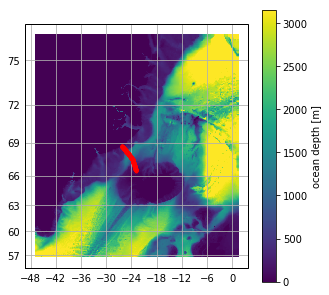

In [8]:
# Plot map and mooring locations
fig = plt.figure(figsize=(5, 5))
ax = od.plot.horizontal_section(varName='Depth')
XC = od_moor.dataset['XC'].squeeze()
YC = od_moor.dataset['YC'].squeeze()
line = ax.plot(XC, YC, 'r.',
               transform=ccrs.PlateCarree())

<xgcm.Grid>
Y Axis (not periodic):
  * center   Y --> outer
  * outer    Yp1 --> center
X Axis (not periodic):
  * center   X --> outer
  * outer    Xp1 --> center
mooring Axis (not periodic):
  * center   mooring_midp --> outer
  * outer    mooring --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
time Axis (not periodic):
  * center   time_midp --> outer
  * outer    time --> center

Coordinates:
  * mooring_midp       (mooring_midp) float64 0.5 1.5 2.5 ... 187.5 188.5 189.5
  * Z                  (Z) float64 -1.0 -3.5 -7.0 ... -1.732e+03 -1.746e+03
    YC                 (mooring, Y, X) float64 ...
  * mooring            (mooring) int64 0 1 2 3 4 5 6 ... 185 186 187 188 189 190
  * Y                  (Y) int64 0
  * X                  (X) int64 0
    XC                 (mooring, Y, X) float64 ...
    YU                 (mooring, Y, Xp1) float64 ...
  * Xp1                (Xp1) int64 0 1
    XU 

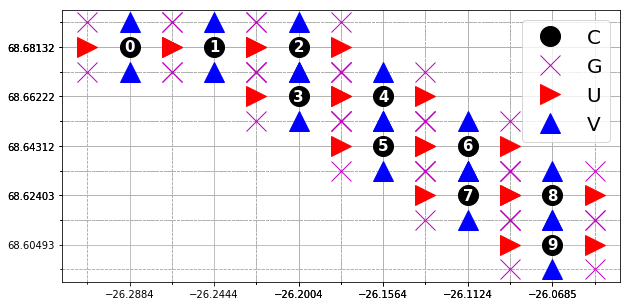

In [9]:
# Print grid
print(od_moor.grid)
print()
print(od_moor.dataset.coords)
print()

# Plot 10 moorings and their grid points
fig, ax = plt.subplots(1, 1)
n_moorings = 10
# Markers:
for _, (pos, mark, col) in enumerate(zip(['C', 'G', 'U', 'V'],
                                         ['o', 'x', '>', '^'],
                                         ['k', 'm', 'r', 'b'])):
    X = od_moor.dataset['X'+pos].values[:n_moorings].flatten()
    Y = od_moor.dataset['Y'+pos].values[:n_moorings].flatten()
    ax.plot(X, Y, col+mark, markersize=20, label=pos)
    if pos == 'C':
        for i in range(n_moorings):
            ax.annotate(str(i), (X[i], Y[i]),
                        size=15, weight="bold", color='w', ha='center', va='center') 
        ax.set_xticks(X, minor=False)
        ax.set_yticks(Y, minor=False)
    elif pos == 'G':
        ax.set_xticks(X, minor=True)
        ax.set_yticks(Y, minor=True)
ax.legend(prop={'size': 20})
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle='--')

## Plots
### Vertical sections
We can now use OceanSpy to plot vertical sections. Here we plot isopycnal contours on top of the mean meridional velocities (`V`). Although there are two V-points associated with each mooring, the plot can be displayed because OceanSpy automatically performs a linear interpolation using the grid object.

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Computing weighted_mean.
Regridding [w_mean_V] along [Y]-axis.
Computing weighted_mean.


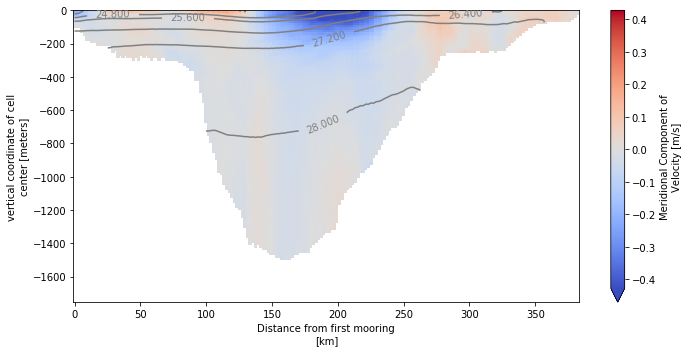

In [10]:
# Plot time mean
ax = od_moor.plot.vertical_section(varName='V', contourName='Sigma0', meanAxes='time',
                                   robust=True, cmap='coolwarm')

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Regridding [V] along [Y]-axis.


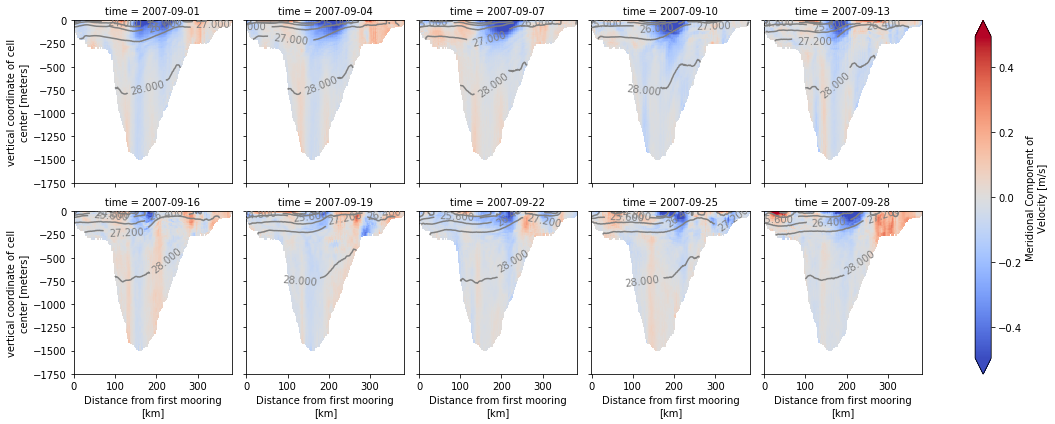

In [11]:
# Plot all snapshots
ax = od_moor.plot.vertical_section(varName='V', contourName='Sigma0',
                                   robust=True, cmap='coolwarm', col_wrap=5)
# Alternatively, use the following command to produce a movie:
# anim = od_moor.animate.vertical_section(varName='V', contourName='Sigma0', ...)

### TS-diagrams
Here we use OceanSpy to plot a Temperature-Salinity diagram.

Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


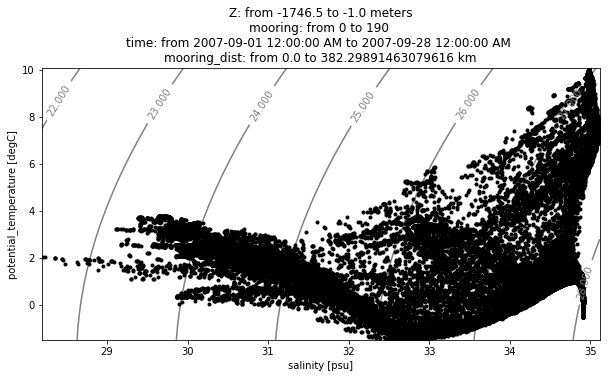

In [12]:
ax = od_moor.plot.TS_diagram()
# Alternatively, use the following command
# to explore how the water masses change with time:
# anim = od_moor.animate.TS_diagram()

We can also color each TS point using any field in the original dataset, or any field computed by OceanSpy. Fields that are not on the same grid of temperature and salinity are automatically regridded by OceanSpy.

Computing weighted_mean.
Computing weighted_mean.
Interpolating [V] along [Y]-axis.
Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


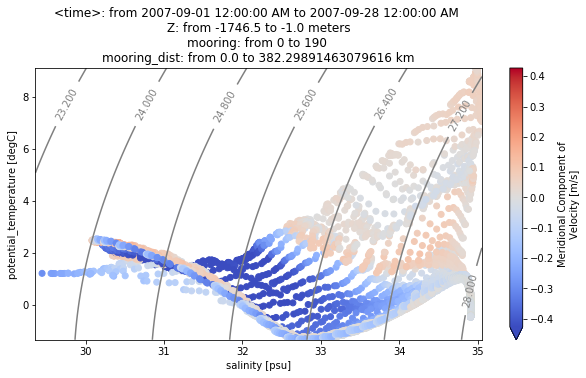

In [13]:
ax = od_moor.plot.TS_diagram(colorName='V',
                             meanAxes='time',
                             cmap_kwargs={'robust': True,
                                          'cmap': 'coolwarm'})

## Volume flux
OceanSpy can be used to compute accurate volume fluxes through vertical sections.
The function `compute.mooring_volume_transport` calculates the inflow/outflow through all grid faces of the vertical section. 
This function creates a new dimension named `path` because transports can be computed using two paths (see the plot below). 

Computing horizontal volume transport.
<xarray.Dataset>
Dimensions:         (Z: 123, mooring: 191, path: 2, time: 10)
Coordinates:
  * Z               (Z) float64 -1.0 -3.5 -7.0 ... -1.732e+03 -1.746e+03
  * mooring         (mooring) int64 0 1 2 3 4 5 6 ... 185 186 187 188 189 190
    Y               int64 0
    YU              (mooring) float64 68.68 68.68 68.68 ... 66.52 66.5 66.49
  * time            (time) datetime64[ns] 2007-09-01 2007-09-04 ... 2007-09-28
    mooring_dist    (mooring) float64 0.0 1.778 3.556 ... 378.1 380.2 382.3
  * path            (path) int64 0 1
    X               int64 0
    XV              (mooring) float64 -26.29 -26.24 -26.2 ... -22.99 -22.99
    YC              (mooring) float64 68.68 68.68 68.68 ... 66.52 66.5 66.49
    XC              (mooring) float64 -26.29 -26.24 -26.2 ... -22.99 -22.99
Data variables:
    transport       (time, Z, mooring, path) float64 nan nan ... nan nan
    Vtransport      (time, Z, mooring, path) float64 nan nan ... nan nan
  

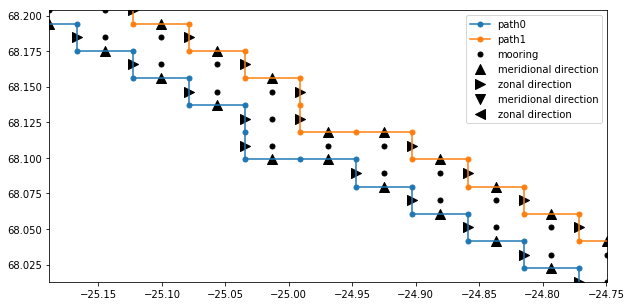

In [14]:
# Show volume flux variables
ds_Vflux = ospy.compute.mooring_volume_transport(od_moor)
od_moor = od_moor.merge_into_oceandataset(ds_Vflux)
print(ds_Vflux)

# Plot 10 moorings and volume flux directions.
fig, ax = plt.subplots(1, 1)
ms = 10
s = 100
ds = od_moor.dataset
_ = ax.step(ds['XU'].isel(Xp1=0).squeeze(),
            ds['YV'].isel(Yp1=0).squeeze(), 'C0.', ms=ms, label='path0')
_ = ax.step(ds['XU'].isel(Xp1=1).squeeze(),
            ds['YV'].isel(Yp1=1).squeeze(), 'C1.', ms=ms, label='path1')
_ = ax.plot(ds['XC'].squeeze(),
            ds['YC'].squeeze(), 'k.', ms=ms, label='mooring')
_ = ax.scatter(ds['X_Vtransport'].where(ds['dir_Vtransport'] == 1),
               ds['Y_Vtransport'].where(ds['dir_Vtransport'] == 1),
               s=s, c='k', marker='^', label='meridional direction')
_ = ax.scatter(ds['X_Utransport'].where(ds['dir_Utransport'] == 1),
               ds['Y_Utransport'].where(ds['dir_Utransport'] == 1),
               s=s, c='k', marker='>', label='zonal direction')
_ = ax.scatter(ds['X_Vtransport'].where(ds['dir_Vtransport'] == -1),
               ds['Y_Vtransport'].where(ds['dir_Vtransport'] == -1),
               s=s, c='k', marker='v', label='meridional direction')
_ = ax.scatter(ds['X_Utransport'].where(ds['dir_Utransport'] == -1),
               ds['Y_Utransport'].where(ds['dir_Utransport'] == -1),
               s=s, c='k', marker='<', label='zonal direction')
# Only show a few moorings
m_start = 50
m_end = 70
xlim = ax.set_xlim(sorted([ds['XC'].isel(mooring=m_start).values,
                           ds['XC'].isel(mooring=m_end).values]))
ylim = ax.set_ylim(sorted([ds['YC'].isel(mooring=m_start).values,
                           ds['YC'].isel(mooring=m_end).values]))
ax.legend()

Here we compute and plot the cumulative mean transport through the Kögur mooring array.

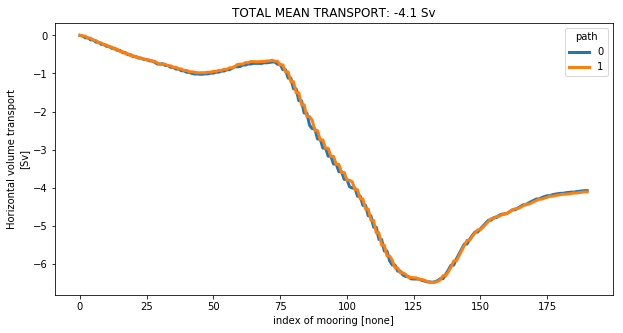

In [15]:
# Compute cumulative transport
tran_moor = od_moor.dataset['transport']
cum_tran_moor = tran_moor.sum('Z').mean('time').cumsum('mooring')
cum_tran_moor.attrs = tran_moor.attrs
fig, ax = plt.subplots(1, 1)
lines = cum_tran_moor.squeeze().plot.line(hue='path', linewidth=3)
tot_mean_tran_moor = cum_tran_moor.isel(mooring=-1).mean('path')
title = ax.set_title('TOTAL MEAN TRANSPORT: {0:.1f} Sv'
                   ''.format(tot_mean_tran_moor.values))

Here we compute the transport of the overflow, defined as water with density greater than 27.8 kg m$^{-3}$.

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


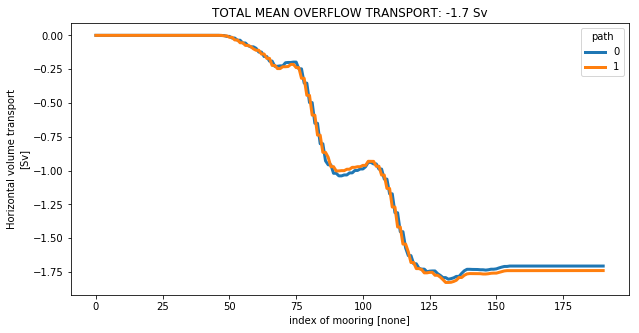

In [16]:
# Mask transport using density
od_moor = od_moor.compute.potential_density_anomaly()
density = od_moor.dataset['Sigma0'].squeeze()
oflow_moor = tran_moor.where(density>27.8)

# Compute cumulative transport as before
cum_oflow_moor = oflow_moor.sum('Z').mean('time').cumsum('mooring')
cum_oflow_moor.attrs = oflow_moor.attrs
fig, ax = plt.subplots(1, 1)
lines = cum_oflow_moor.squeeze().plot.line(hue='path', linewidth=3)
tot_mean_oflow_moor = cum_oflow_moor.isel(mooring=-1).mean('path')
title = ax.set_title('TOTAL MEAN OVERFLOW TRANSPORT: {0:.1f} Sv'
                     ''.format(tot_mean_oflow_moor.values))

## Ship survey
The following picture shows the NATO Research Vessel Alliance, a ship designed to carry out research at sea (source: http://www.marina.difesa.it/noi-siamo-la-marina/mezzi/forze-navali/PublishingImages/_alliance.jpg).
![Survey ship](http://www.marina.difesa.it/noi-siamo-la-marina/mezzi/forze-navali/PublishingImages/_alliance.jpg)  

The OceanSpy function analogous to a ship survey (`compute.survey_stations`) extracts vertical sections from the model using two criteria:

* Vertical sections follow great circle paths (unless cartesian coordinates are used) with constant horizontal spacing between stations.
* Interpolation is performed and all fields are returned at the same locations (the native grid of the model is NOT preserved).

In [17]:
# Spacing between interpolated stations
delta_Kogur = 2 # km

# Extract survey stations
# Reduce dataset to speed things up:
od_surv = od.subsample.survey_stations(Xsurv=lons_Kogur,
                                       Ysurv=lats_Kogur,
                                       delta=delta_Kogur,
                                       ZRange=depth_Kogur,
                                       timeRange=timeRange,
                                       timeFreq=timeFreq,
                                       varList=['Temp', 'S',
                                                'U', 'V',
                                                'drC', 'drF',
                                                'HFacC', 'HFacW', 'HFacS'])

Cutting out the oceandataset.


/home/idies/workspace/Storage/malmans2/persistent/oceanspy/oceanspy/subsample.py:1235: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Carrying out survey.
Create weight file: bilinear_118x76_142x142.nc
Variables to interpolate: ['XC', 'YC', 'XU', 'YU', 'XV', 'YV', 'XG', 'YG', 'HFacC', 'HFacW', 'HFacS', 'U', 'V', 'Temp', 'S'].
Interpolating [XC].
Interpolating [YC].
Interpolating [XU].
Interpolating [YU].
Interpolating [XV].
Interpolating [YV].
Interpolating [XG].
Interpolating [YG].
Interpolating [HFacC].
Interpolating [HFacW].
Interpolating [HFacS].
Interpolating [U].
Interpolating [V].
Interpolating [Temp].
Interpolating [S].
Remove file bilinear_118x76_142x142.nc


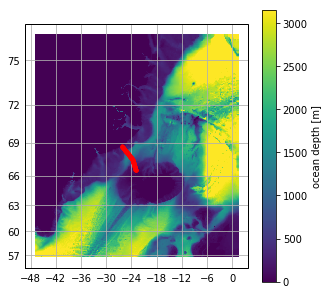

In [18]:
# Plot map and survey stations
fig = plt.figure(figsize=(5, 5))
ax = od.plot.horizontal_section(varName='Depth')
XC = od_surv.dataset['XC'].squeeze()
YC = od_surv.dataset['YC'].squeeze()
line = ax.plot(XC, YC, 'r.',
               transform=ccrs.PlateCarree())

## Orthogonal velocities
We can use OceanSpy to compute the velocity components orthogonal and tangential to the Kögur section.

In [19]:
od_surv = od_surv.compute.survey_aligned_velocities()

Computing survey aligned velocities.


/home/idies/workspace/Storage/malmans2/persistent/oceanspy/oceanspy/compute.py:2926: UserWarning: 
These variables are not available and can not be computed: ['AngleCS', 'AngleSN'].
If you think that OceanSpy should be able to compute them, please open an issue on GitHub:
 https://github.com/malmans2/oceanspy/issues
Assuming U=U_zonal and V=V_merid.
If you are using curvilinear coordinates, run `compute.geographical_aligned_velocities` before `subsample.survey_stations`
  ds = survey_aligned_velocities(self._od, **kwargs)


The following animation shows isopycnal contours on top of the velocity component orthogonal to the Kögur section.

In [20]:
anim = od_surv.animate.vertical_section(varName='ort_Vel', contourName='Sigma0',
                                        robust=True, cmap='coolwarm',
                                        display=False)

# The following code is necessary to display the animation in the documentation.
# When the notebook is executed, remove the code below and set
# display=True in the command above to show the animation.
import matplotlib.pyplot as plt
dirName = '_static'
import os
try:
    os.mkdir(dirName)
except FileExistsError:
    pass
anim.save('{}/Kogur.mp4'.format(dirName))
plt.close()
!ffmpeg -loglevel panic -y -i _static/Kogur.mp4 -filter_complex "[0:v] fps=12,scale=480:-1,split [a][b];[a] palettegen [p];[b][p] paletteuse" _static/Kogur.gif
!rm -f _static/Kogur.mp4

![Kogur gif](_static/Kogur.gif)

Finally, we can infer the volume flux by integrating the orthogonal velocities.

In [21]:
# Integrate along Z
od_surv = od_surv.compute.integral(varNameList='ort_Vel',
                                   axesList=['Z'])
# Compute transport using weights
od_surv = od_surv.compute.weighted_mean(varNameList='I(ort_Vel)dZ',
                                        axesList=['station'])
transport_surv = (od_surv.dataset['I(ort_Vel)dZ'] * 
                  od_surv.dataset['weight_I(ort_Vel)dZ'])
# Convert in Sverdrup
transport_surv = transport_surv * 1.E-6
# Compute cumulative transport
cum_transport_surv = transport_surv.cumsum('station').rename('Horizontal volume transport')
cum_transport_surv.attrs['units'] = 'Sv'

Computing integral.
Computing weighted_mean.


Here we plot the cumulative transport for each snapshot.

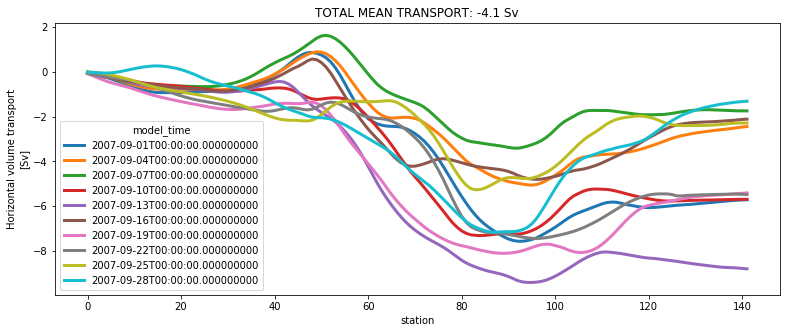

In [22]:
# Plot
fig, ax = plt.subplots(figsize=(13,5))
lines = cum_transport_surv.squeeze().plot.line(hue='time', linewidth=3)
tot_mean_transport = cum_transport_surv.isel(station=-1).mean('time')
title = ax.set_title('TOTAL MEAN TRANSPORT: {0:.1f} Sv'.format(tot_mean_transport.values))